In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import sys, os

sys.path.append('../')
from src.utils import load_config, split_into_sentences, flatten_list, clean_generated_data
from src import stats_analysis as sa

## ML

import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import shap
import seaborn as sns

[nltk_data] Downloading package punkt to /home/robin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
config = load_config('../config.yaml')
data = pd.read_pickle(config['agg_file'])
len(data)
def encode_temperature(temperature):
    if temperature <2 :
        return "low"
    elif temperature <4 :
        return "medium"
    else : 
        return "high"

data['temperature_enc'] = data['temperature'].apply(encode_temperature)
original_data = data.copy()
print("len of original data:", len(data))
data = clean_generated_data(data)
print("len of cleaned data:", len(data))




len of original data: 22953
Data contains at the begining : 22953
Filtering data with more than 20 sentences and less than 5 sentences. 20947 samples left
Filtering data with phone numbers. 20908 samples left
Filtering data with addresses. 20540 samples left
Filtering data with mail addresses. 20540 samples left
Filtering data with list. 20022 samples left
Filtering data with short paraphrase. 19048 samples left
Filtering data with paraphrase at the end. 18848 samples left
len of cleaned data: 18848


In [5]:
original_data['num_sentences'].describe()

count    22953.000000
mean         9.570339
std          3.112539
min          2.000000
25%          7.000000
50%          9.000000
75%         12.000000
max         19.000000
Name: num_sentences, dtype: float64

In [10]:
data.temperature_enc.value_counts()

temperature_enc
medium    6673
low       6543
high      5632
Name: count, dtype: int64

In [4]:
density_features = data.filter(regex = "score").columns.tolist()

sim_features = data.filter(regex='mean|std').columns.tolist()

scores = data.filter(regex='score').columns.tolist()
mean_sim_metrics = data.filter(regex = '(sentence_sim|w2v|glove|fast_text|jaccard)(.*)(mean)').columns.tolist()
std_sim_metrics = data.filter(regex = '(sentence_sim|w2v|glove|fast_text|jaccard)(.*)(std)').columns.tolist()

all_features = density_features + sim_features

target = ['temperature_enc', "has_paraphrase"]


continuous_features = data[all_features]
categorical_features = data[target]

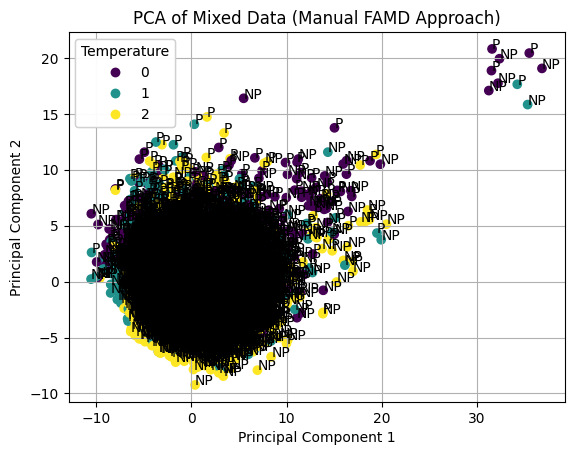

In [9]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt


encoder = OneHotEncoder()
categorical_encoded = encoder.fit_transform(categorical_features).toarray()
categorical_encoded_df = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out(categorical_features.columns))

# Standardize continuous features
scaler = StandardScaler()
continuous_scaled = scaler.fit_transform(continuous_features)

# Combine all features
combined_features = np.hstack((continuous_scaled, categorical_encoded_df))

# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(combined_features)
principal_df = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])

# Plotting the results
fig, ax = plt.subplots()
scatter = ax.scatter(principal_df['PC1'], principal_df['PC2'], c=pd.factorize(data['temperature_enc'])[0], cmap='viridis', label=data['temperature_enc'])

# Create a legend for temperatures
legend1 = ax.legend(*scatter.legend_elements(), title="Temperature")
ax.add_artist(legend1)

# Annotate points for paraphrase presence
for i, txt in enumerate(data['has_paraphrase']):
    ax.annotate('P' if txt else 'NP', (principal_df.loc[i, 'PC1'], principal_df.loc[i, 'PC2']))

plt.title('PCA of Mixed Data (Manual FAMD Approach)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

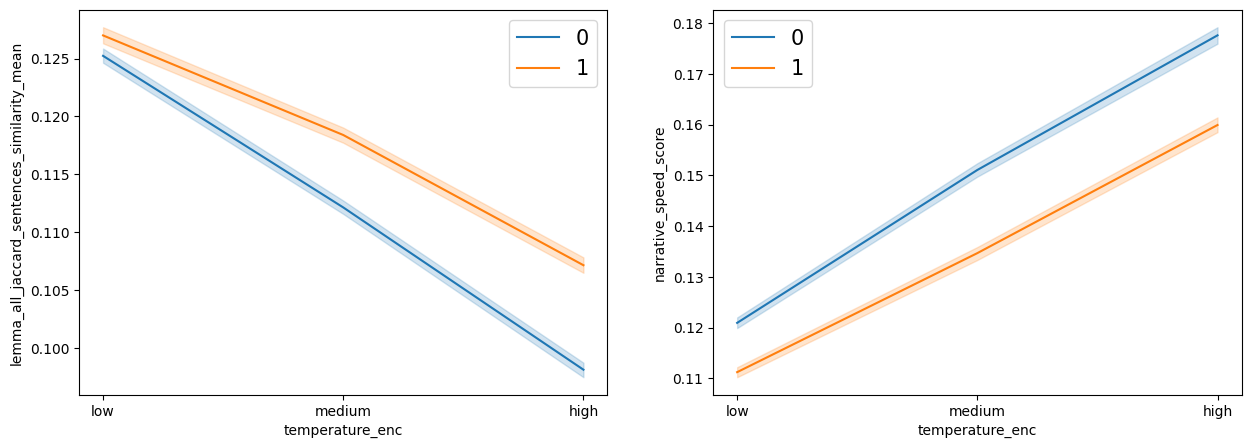

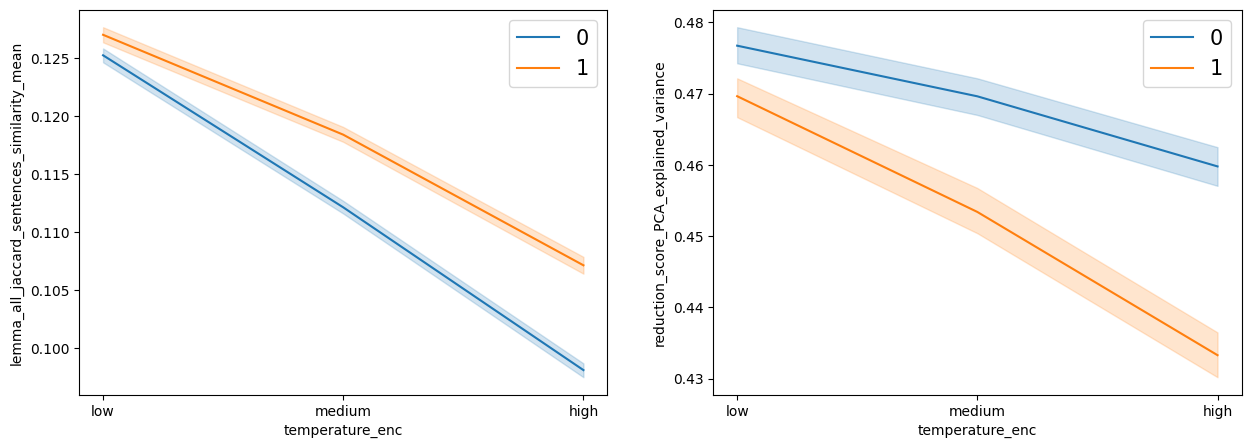

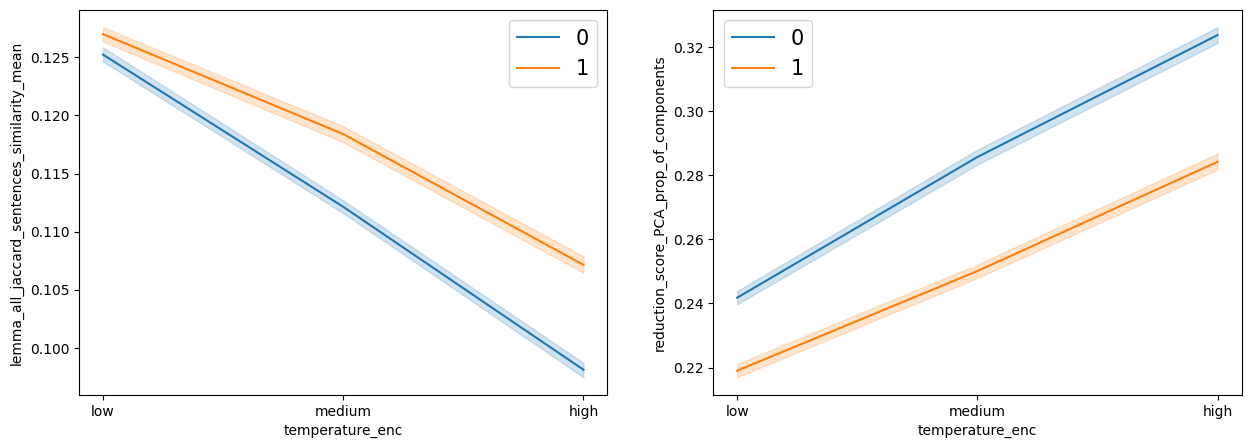

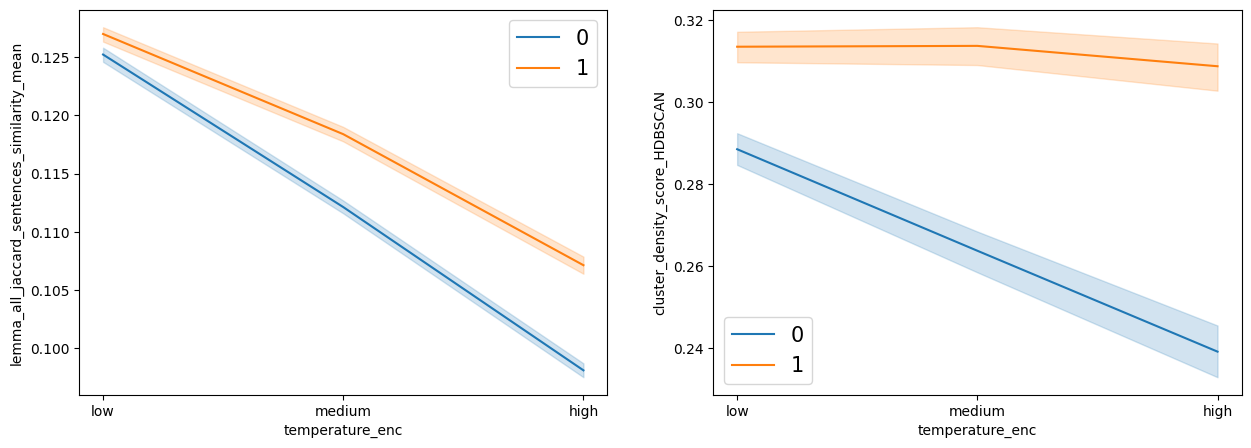

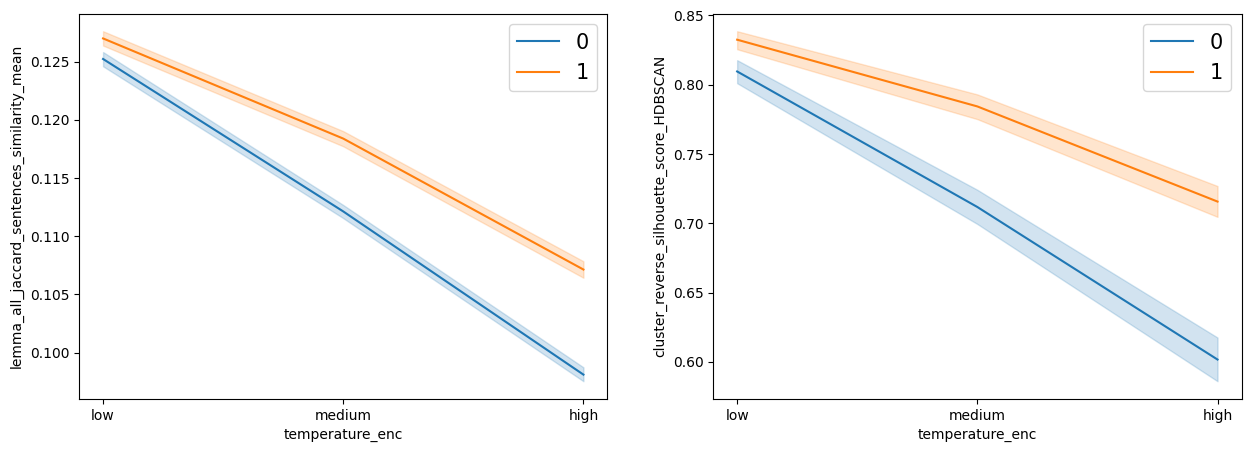

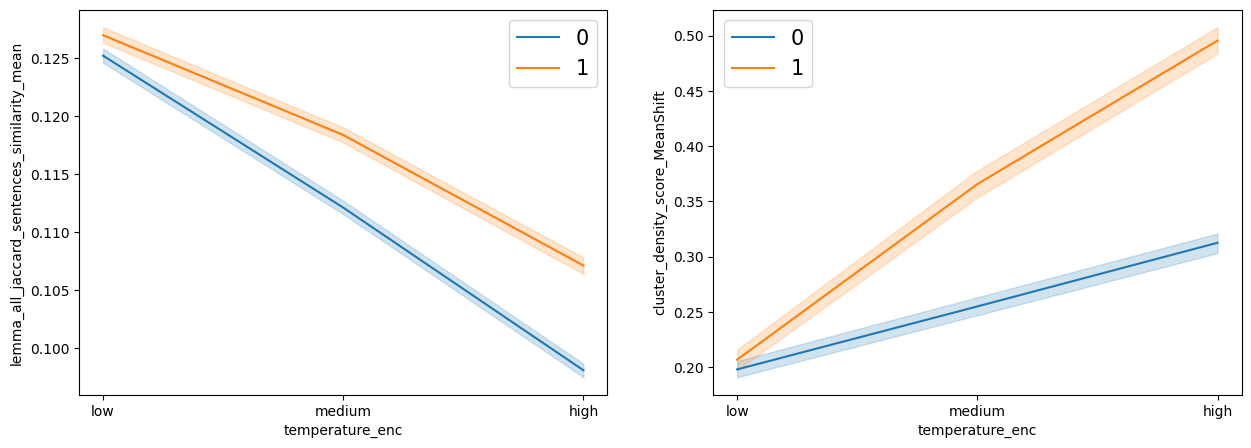

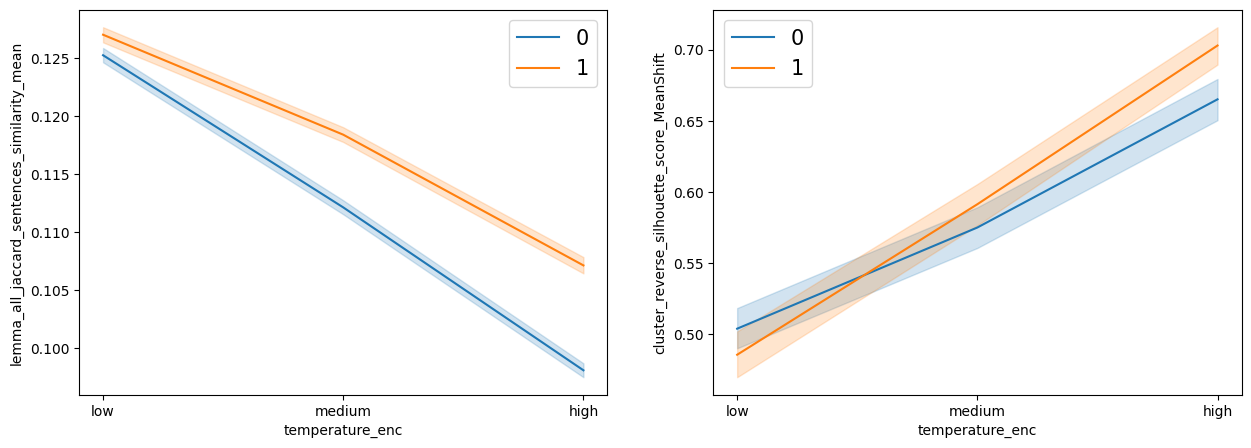

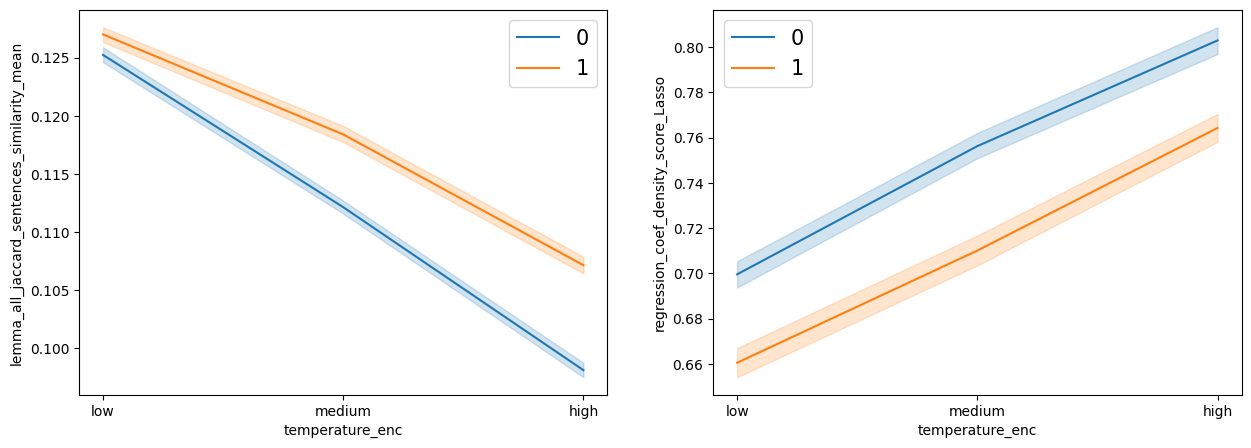

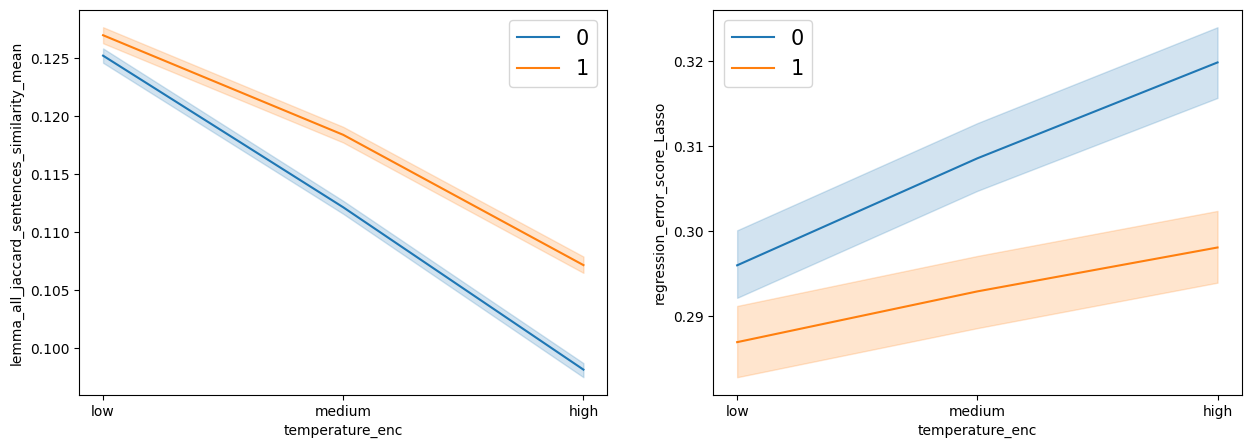

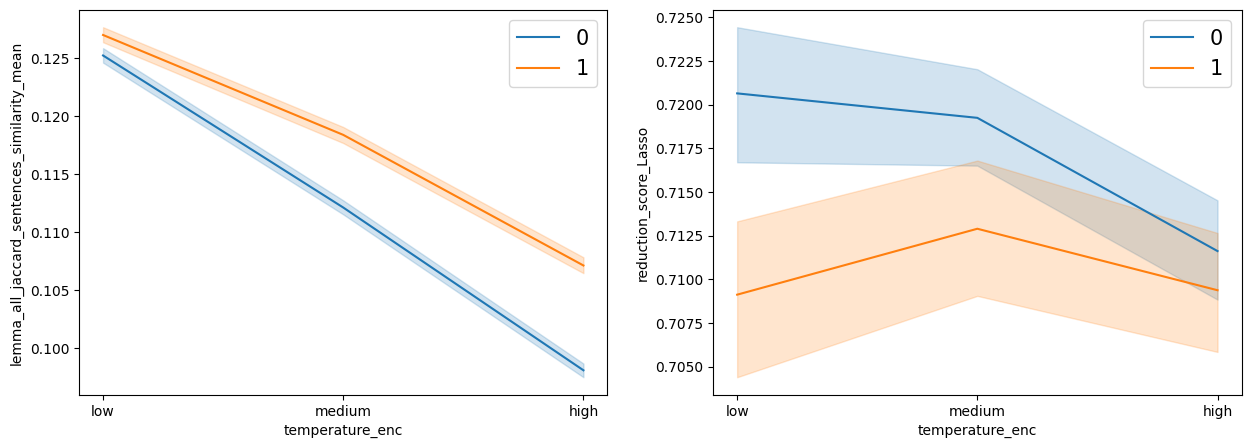

In [7]:
def compare_twio_features(data, feature1, feature2):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.lineplot(data = data, y = feature1,x = "temperature_enc",  hue = "has_paraphrase",ax = axes[0])
    sns.lineplot(data = data, y = feature2 ,x = "temperature_enc",  hue = "has_paraphrase",ax = axes[1])
    axes[0].legend(fontsize = 15)
    axes[1].legend(fontsize = 15)
    plt.show()

featureA = "lemma_all_jaccard_sentences_similarity_mean"
for featureB in scores:
    compare_twio_features(data, featureA, featureB)

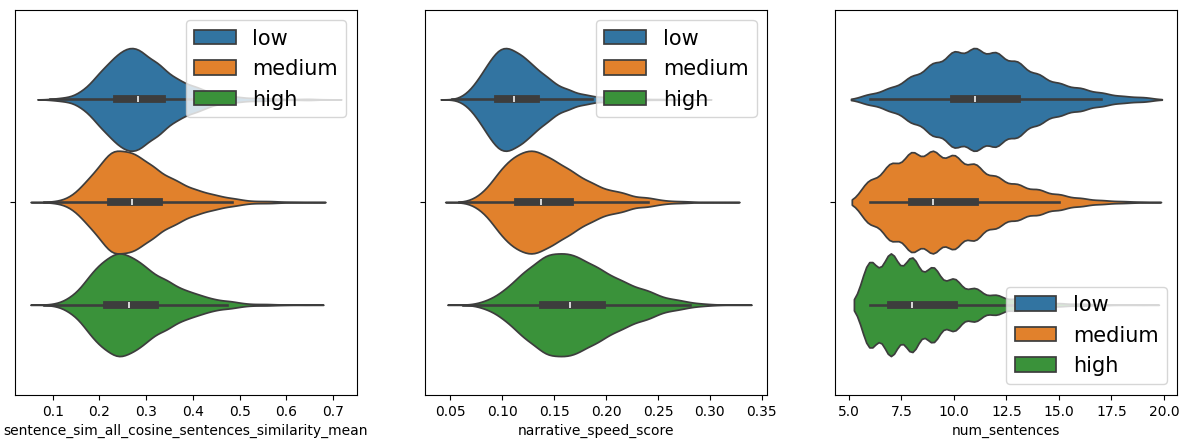

In [61]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
sns.violinplot(data = data, x = "sentence_sim_all_cosine_sentences_similarity_mean",hue = "temperature_enc", ax = axes[0]) # , hue = "has_paraphrase")
#plt.sublegend(fontsize = 15)
sns.violinplot(data = data, x = "narrative_speed_score",hue = "temperature_enc", ax = axes[1], )
sns.violinplot(data = data, x = "num_sentences",hue = "temperature_enc", ax = axes[2], )

axes[0].legend(fontsize = 15)
axes[1].legend(fontsize = 15)
axes[2].legend(fontsize = 15)

In [ ]:
data.filter(regex='sentence').columns.tolist()

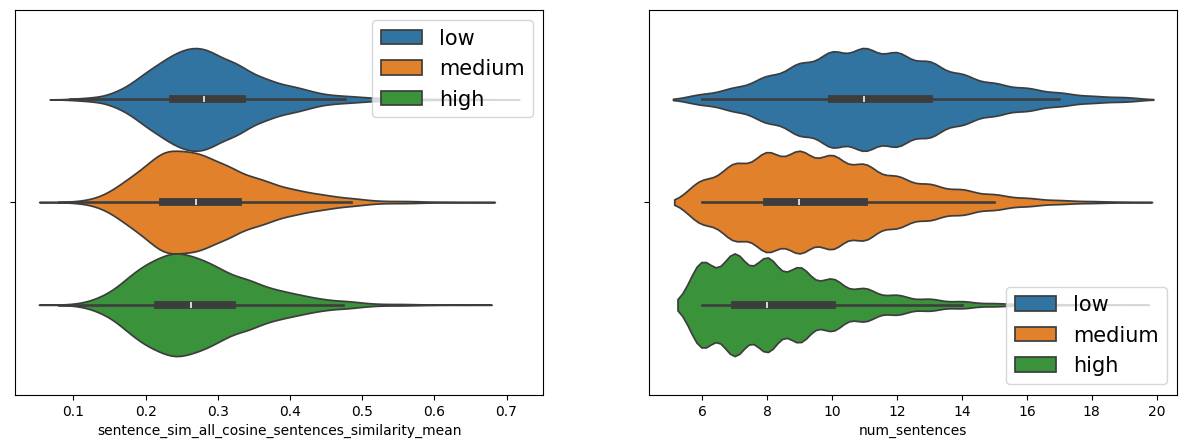

In [58]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.violinplot(data = data, x = "sentence_sim_all_cosine_sentences_similarity_mean",hue = "temperature_enc", ax = axes[0]) # , hue = "has_paraphrase")
#plt.sublegend(fontsize = 15)
sns.violinplot(data = data, x = "num_sentences",hue = "temperature_enc", ax = axes[1], )
axes[0].legend(fontsize = 15)
axes[1].legend(fontsize = 15)

<Axes: xlabel='narrative_speed_score'>

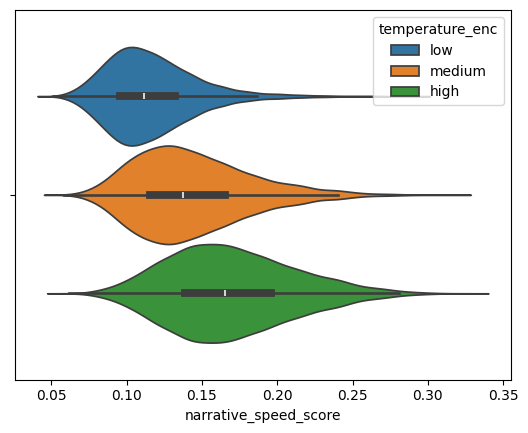

In [55]:
sns.violinplot(data = data, x = "narrative_speed_score",hue = "temperature_enc")

In [ ]:
sa.compute_anova_table(data, cible = ['temperature_enc'], col_list = all_features, seuil=0.01).sort_values("np2", ascending = False)

In [5]:
print(len(data))
print(data.source.value_counts())
print(data.groupby('source').had_paraphrase.value_counts())

18848
source
gpt2      9443
pythia    9405
Name: count, dtype: int64
source  had_paraphrase
gpt2    False             5285
        True              4158
pythia  False             5221
        True              4184
Name: count, dtype: int64


In [7]:
data.paraphrase_model.value_counts()

paraphrase_model
gpt-3.5-turbo    6963
-1               1064
Name: count, dtype: int64

## 1. Context

The dataset contains generate story using GPT-2 model and Pythia model. 
Some of this story contains paraphrase and others not. The paraphrase were generated and inserted using GPT-3.5 model or ibm-paraphraser.
In previous experiment, we have demonstrated some statistical association between semantic and similarity features and paraphrase detection. In this notebook, we will use the same features to train a model to detect paraphrase in the dataset.

Our objectives are the followings :
1- Quantify the prediction power of these features to detect semantic repetition (paraphrase)
2- Order and identify the most important features for the prediction
3- Evaluate the impact of paraphrasing on the text when removing the paraphraseed.

The AUC scores will be used to evaluate the model. In first experiment we will  use interpretable simple model (like logistic regression or Random Forest) to identify the most important features. In a second experiment, we will use a more complex model (like XGBoost) and use SHAP to explain the prediction.

## 2. Data and features

In [3]:

print(len(data))
offline_data = data[data.paraphrase_model == -1]
print(len(offline_data))
online_data = data[data.paraphrase_model != -1]
print(len(online_data))

online_data['consecutive_paraphrase'] =online_data.apply(lambda x: 1 if (x.clean_paraphrase_index[1]-x.clean_paraphrase_index[0])==1 else 0, axis=1)
online_data["distant_paraphrase"] = online_data.apply(lambda x: 1 if (x.clean_paraphrase_index[1]-x.clean_paraphrase_index[0])/x.num_sentences>0.25 else 0, axis=1)


# ability to detect diffucult paraphrase

#semantic_repetition_data = data[(data['has_semantic repetition'] == 1)]

data.head()

18848
1522
17326


index                        prompt  \
0      0  Most people start the day by   
1      1  Most people start the day by   
2      2  Most people start the day by   
3      3  Most people start the day by   
4      4  Most people start the day by   

                                      generated_text model_name  temperature  \
0  Most people start the day by getting out of be...       gpt2     1.031016   
1  Most people start the day by waking up in the ...       gpt2     0.942180   
2  Most people start the day by getting up and go...       gpt2     0.911323   
3  Most people start the day by eating breakfast,...       gpt2     0.986080   
4  Most people start the day by getting up and go...       gpt2     1.020512   

   num_beams                                               text llm_model  \
0          5  Most people start the day by getting out of be...      gpt2   
1          5  Most people start the day by waking up in the ...      gpt2   
2          5  Most people start the day by getting up and go...      gpt2   
3          5  Most people start the day by eating breakfast ...      gpt2   
4          4  Most people start the day by getting up and go...      gpt2   

  paraphrase_model                                       altered_text  ...  \
0               -1  Most people start the day by getting out of be...  ...   
1               -1  Most people start the day by waking up in the ...  ...   
2               -1  Most people start the day by getting up and go...  ...   
3               -1  Most people start the day by eating breakfast ...  ...   
4               -1  Most people start the day by getting up and go...  ...   

   reduction_score_Lasso has_phone has_address  has_mail  has_list  \
0               0.846154         0           0         0     False   
1               0.666667         0           0         0     False   
2               0.818182         0           0         0     False   
3               0.777778         0           0         0     False   
4               0.666667         0           0         0     False   

   paraphrase_is_short  paraphrase_at_end has_paraphrase  prompt_cat  \
0                    0                  0              0           2   
1                    0                  0              0           2   
2                    0                  0              0           2   
3                    0                  0              0           2   
4                    0                  0              0           2   

   has_lexical_repetition  
0                       0  
1                       0  
2                       0  
3                       0  
4                       0  

[5 rows x 160 columns]

In [5]:
density_features = data.filter(regex = "score").columns.tolist()

sim_features = data.filter(regex='mean|std').columns.tolist()

scores = data.filter(regex='score').columns.tolist()
mean_sim_metrics = data.filter(regex = '(sentence_sim|w2v|glove|fast_text|jaccard)(.*)(mean)').columns.tolist()
std_sim_metrics = data.filter(regex = '(sentence_sim|w2v|glove|fast_text|jaccard)(.*)(std)').columns.tolist()

all_features = density_features + sim_features

print(len(all_features))


42


In [25]:
def build_pipeline(model):
    if model == "LR":
        clf = LogisticRegression()
    elif model == "random_forest":
        clf = RandomForestClassifier()
    elif model == "xgb":
        clf = XGBClassifier()
    elif model == "svm":
        clf = SVC(probability=True)
    elif model == "kernel_svm":
        clf = SVC(kernel='linear', probability=True)

    # Define k-cross validation
    skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

    # Define function to compute AUC score
    def compute_auc(X, y, model):
        return roc_auc_score(y, model.predict_proba(X)[:, 1])

    # Define function to extract feature importance using SHAP
    def extract_shap(X, model):
        try : 
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X)
            shap.summary_plot(shap_values, X,)# plot_type="bar")
        except Exception as e:
            print(e)
            shap_values = None
        return shap_values

    # Define the pipeline
    def pipeline(X, y,group, extract_shap_val = False) :
        # Train the model using k-cross validation
        auc_scores = cross_val_score(clf, X, y,groups=group, cv=skf, scoring="roc_auc")
        print(f"AUC scores: {auc_scores}")
        print(f"Mean AUC: {np.mean(auc_scores)}")

        # Fit the model on the whole dataset
        clf.fit(X, y)

        # Extract and show feature importance
        if extract_shap_val:
            shap_values = extract_shap(X, clf)
        else:
            shap_values = None
        perf = np.mean(auc_scores)
        return clf, perf, shap_values

    return pipeline



def compare_models(models, X, y, group,extract_shap_val=False):
    results = {}
    for model_name, model in models.items():
        pipeline = build_pipeline(model)
        clf, perf, shap_values = pipeline(X, y, group,extract_shap_val=extract_shap_val)
        results[model_name] = perf
    results_df = pd.DataFrame(results, index=["Mean AUC"])
    return results_df

In [112]:
import itertools


from joblib import Parallel, delayed
import multiprocessing

target = "has_paraphrase"
models = {
    "Logistic Regression": "LR",
    "Random Forest": "random_forest",
    "XGBoost": "xgb",
}


def evaluate_combination(data, feature_combinations_dict, target, models):
    df_results_2 = pd.DataFrame(columns=['n_features', 'features', "feature_name",'auc_lr', 'auc_rf',"auc_xgb",'temperature'])
    i = 0
    for temp in ['low', 'medium', 'high']:
        for key, feature_combination in feature_combinations_dict.items():
            print("#######")
            print(f"n = {key}")
            dataset = data[data['temperature_enc'] == temp]
            results = compare_models(models, dataset[list(feature_combination)], dataset[target], dataset['prompt_cat'], extract_shap_val=False)
            r = {
                'n_features': len(feature_combination),
                'features': feature_combination,
                'feature_name': key,
                'auc_lr': results["Logistic Regression"].values[0],
                'auc_rf': results["Random Forest"].values[0],
                'auc_xgb': results["XGBoost"].values[0],
                'temperature' : temp
            }
            df_results_2.loc[i] = pd.Series(r)
            i += 1
        
    return df_results_2


#feature_combinations = list(itertools.product(scores, mean_sim_metrics, std_sim_metrics))
feature_combinations = [mean_sim_metrics, std_sim_metrics, scores, mean_sim_metrics+std_sim_metrics, mean_sim_metrics+scores, std_sim_metrics+scores, mean_sim_metrics+std_sim_metrics+scores]
feature_combinations_dict = {
    "mean_sim_metrics": mean_sim_metrics,
    "std_sim_metrics": std_sim_metrics,
    "scores": scores,
    "mean_sim_metrics+std_sim_metrics": mean_sim_metrics+std_sim_metrics,
    "mean_sim_metrics+scores": mean_sim_metrics+scores,
    "std_sim_metrics+scores": std_sim_metrics+scores,
    "mean_sim_metrics+std_sim_metrics+scores": mean_sim_metrics+std_sim_metrics+scores
}
# Parallelize the evaluation
#df_results_2 = evaluate_combination(data, feature_combinations_dict, target, models)

one_feature_combinations_dict = { feature : [feature] for feature in all_features}
two_feature_combinations_dict = { "_and_".join(feature) : feature for feature in list(set(itertools.product(scores,mean_sim_metrics)))}
#df_results_1 = evaluate_combination(data, one_feature_combinations_dict, target, models)
df_results_4 = evaluate_combination(data, two_feature_combinations_dict, target, models)


#######
n = regression_coef_density_score_Lasso_and_sentence_sim_all_cosine_sentences_similarity_mean
AUC scores: [0.63401928 0.62534815 0.58809523 0.58883387 0.59718998]
Mean AUC: 0.606697301701929
AUC scores: [0.55140406 0.55748802 0.51727251 0.5224594  0.53967952]
Mean AUC: 0.5376607005141165
AUC scores: [0.57720213 0.59950841 0.5454885  0.53241533 0.55722377]
Mean AUC: 0.562367627498799
#######
n = cluster_density_score_HDBSCAN_and_lemma_all_jaccard_sentences_similarity_mean
AUC scores: [0.55098644 0.5774482  0.59797264 0.54277116 0.53831784]
Mean AUC: 0.5614992529177395
AUC scores: [0.52837802 0.54007353 0.47602496 0.48989749 0.52358842]
Mean AUC: 0.5115924860434603
AUC scores: [0.53790478 0.56936135 0.50420724 0.53576106 0.54509691]
Mean AUC: 0.5384662674560393
#######
n = cluster_density_score_MeanShift_and_w2v_consecutive_wmd_sentences_similarity_mean
AUC scores: [0.51599047 0.50405247 0.54762065 0.5169963  0.49843392]
Mean AUC: 0.5166187618987075
AUC scores: [0.56282977 0.5331

In [100]:
df_results_3.to_csv("two_feature_auc_results.csv")

In [103]:
df_results_3['max_auc'] = df_results_3[['auc_lr', 'auc_rf',"auc_xgb"]].max(axis=1)
df_results_3

n_features                                           features  \
0            2  (regression_coef_density_score_Lasso, fast_tex...   
1            2  (reduction_score_PCA_explained_variance, lemma...   
2            2  (regression_error_score_Lasso, glove_consecuti...   
3            2  (regression_error_score_Lasso, fast_text_conse...   
4            2  (cluster_density_score_MeanShift, glove_consec...   
..         ...                                                ...   
475          2  (regression_error_score_Lasso, w2v_all_wmd_sen...   
476          2  (narrative_speed_score, w2v_all_cosine_sentenc...   
477          2  (cluster_reverse_silhouette_score_MeanShift, w...   
478          2  (reduction_score_PCA_prop_of_components, glove...   
479          2  (cluster_density_score_MeanShift, lemma_all_ja...   

                                          feature_name    auc_lr    auc_rf  \
0    regression_coef_density_score_Lasso_and_fast_t...   0.57852  0.528335   
1    reduction_score_PCA_explained_variance_and_lem...   0.59317  0.558964   
2    regression_error_score_Lasso_and_glove_consecu...  0.528904  0.521986   
3    regression_error_score_Lasso_and_fast_text_con...  0.564884  0.522623   
4    cluster_density_score_MeanShift_and_glove_cons...  0.551467  0.555737   
..                                                 ...       ...       ...   
475  regression_error_score_Lasso_and_w2v_all_wmd_s...  0.742384  0.769684   
476  narrative_speed_score_and_w2v_all_cosine_sente...  0.630291  0.565923   
477  cluster_reverse_silhouette_score_MeanShift_and...  0.762951  0.777546   
478  reduction_score_PCA_prop_of_components_and_glo...  0.657538  0.554368   
479  cluster_density_score_MeanShift_and_lemma_all_...  0.754393  0.834732   

      auc_xgb temperature   max_auc  
0    0.548573         low   0.57852  
1    0.572388         low   0.59317  
2    0.514703         low  0.528904  
3    0.525693         low  0.564884  
4    0.579414         low  0.579414  
..        ...         ...       ...  
475  0.778527        high  0.778527  
476   0.57405        high  0.630291  
477  0.799587        high  0.799587  
478  0.610464        high  0.657538  
479  0.867278        high  0.867278  

[480 rows x 8 columns]

In [111]:
df_results_3[df_results_3['temperature'] == 'high'].sort_values('max_auc', ascending = False)

n_features                                           features  \
479          2  (cluster_density_score_MeanShift, lemma_all_ja...   
325          2  (cluster_reverse_silhouette_score_HDBSCAN, lem...   
342          2  (cluster_density_score_MeanShift, fast_text_al...   
436          2  (reduction_score_Lasso, lemma_all_jaccard_sent...   
438          2  (cluster_density_score_MeanShift, w2v_all_wmd_...   
..         ...                                                ...   
451          2  (reduction_score_Lasso, w2v_all_cosine_sentenc...   
381          2  (reduction_score_Lasso, glove_consecutive_cosi...   
391          2  (reduction_score_Lasso, glove_all_cosine_sente...   
397          2  (reduction_score_Lasso, fast_text_all_cosine_s...   
389          2  (reduction_score_Lasso, w2v_consecutive_cosine...   

                                          feature_name    auc_lr    auc_rf  \
479  cluster_density_score_MeanShift_and_lemma_all_...  0.754393  0.834732   
325  cluster_reverse_silhouette_score_HDBSCAN_and_l...  0.796219  0.845238   
342  cluster_density_score_MeanShift_and_fast_text_...  0.719027  0.806701   
436  reduction_score_Lasso_and_lemma_all_jaccard_se...  0.847431   0.78585   
438  cluster_density_score_MeanShift_and_w2v_all_wm...  0.717768   0.79744   
..                                                 ...       ...       ...   
451  reduction_score_Lasso_and_w2v_all_cosine_sente...  0.515325  0.513717   
381  reduction_score_Lasso_and_glove_consecutive_co...  0.480741  0.510219   
391  reduction_score_Lasso_and_glove_all_cosine_sen...  0.478412  0.513048   
397  reduction_score_Lasso_and_fast_text_all_cosine...  0.509638  0.519964   
389  reduction_score_Lasso_and_w2v_consecutive_cosi...   0.50609  0.512377   

      auc_xgb temperature   max_auc  
479  0.867278        high  0.867278  
325  0.855599        high  0.855599  
342  0.849517        high  0.849517  
436  0.825067        high  0.847431  
438  0.843398        high  0.843398  
..        ...         ...       ...  
451  0.533519        high  0.533519  
381  0.533336        high  0.533336  
391  0.531115        high  0.531115  
397  0.528791        high  0.528791  
389  0.525546        high  0.525546  

[160 rows x 8 columns]

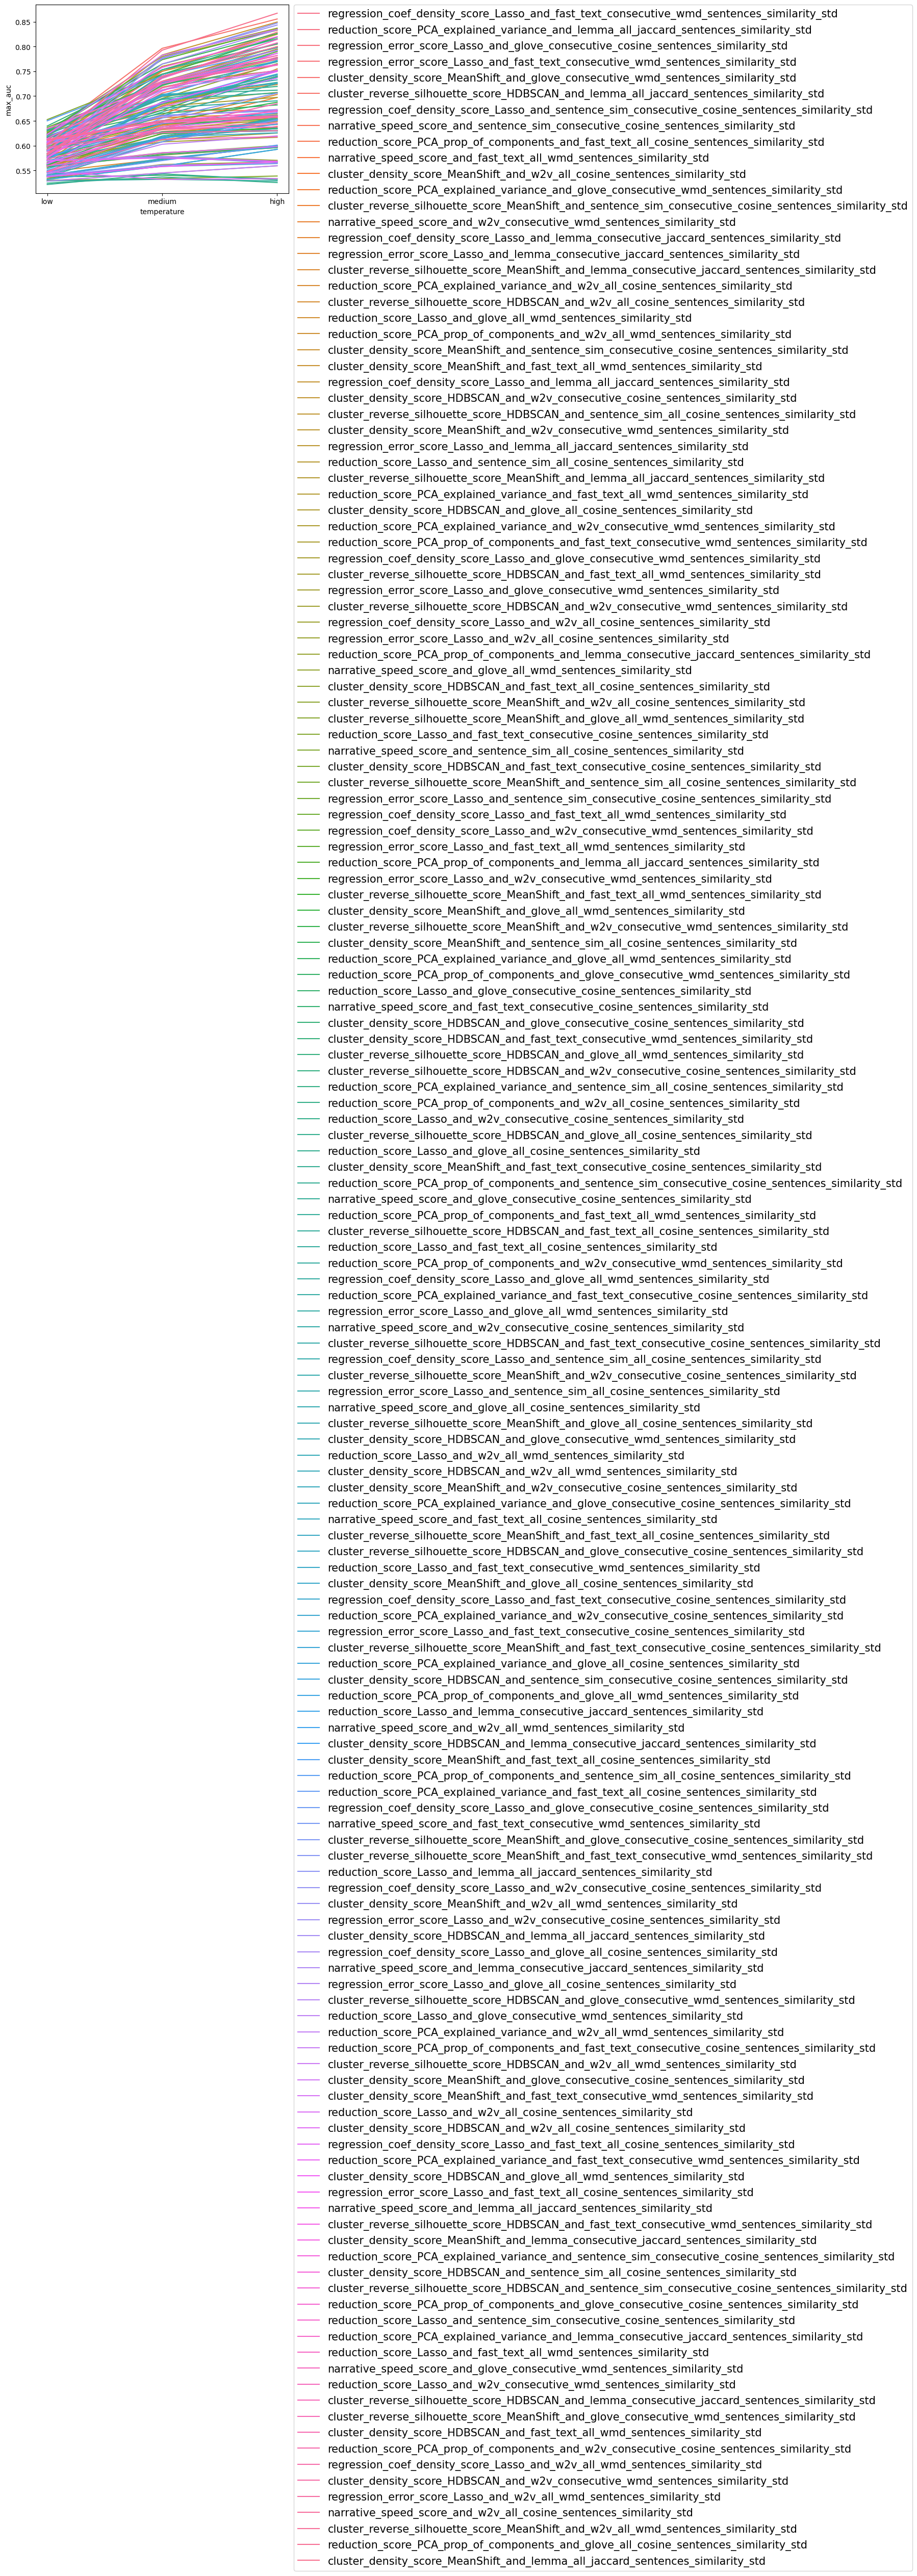

In [106]:
sns.lineplot(data = df_results_3, hue = "feature_name", y = "max_auc" ,x= "temperature")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize = 15)

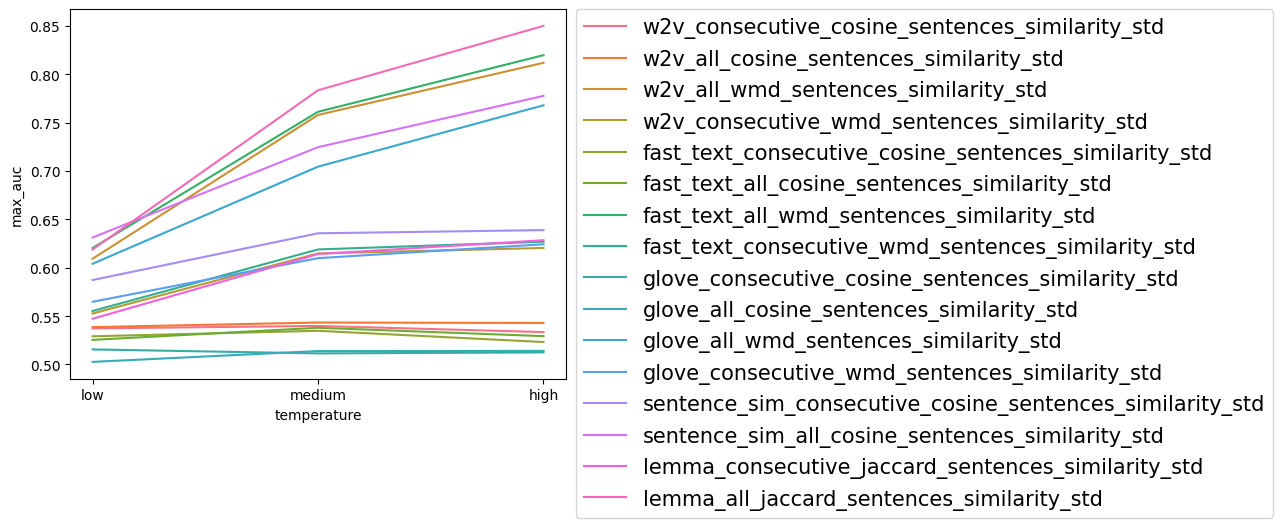

In [80]:
sns.lineplot(data = df_results_1[df_results_1.feature_name.isin(std_sim_metrics)], hue = "feature_name", y = "max_auc" ,x= "temperature")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize = 15)

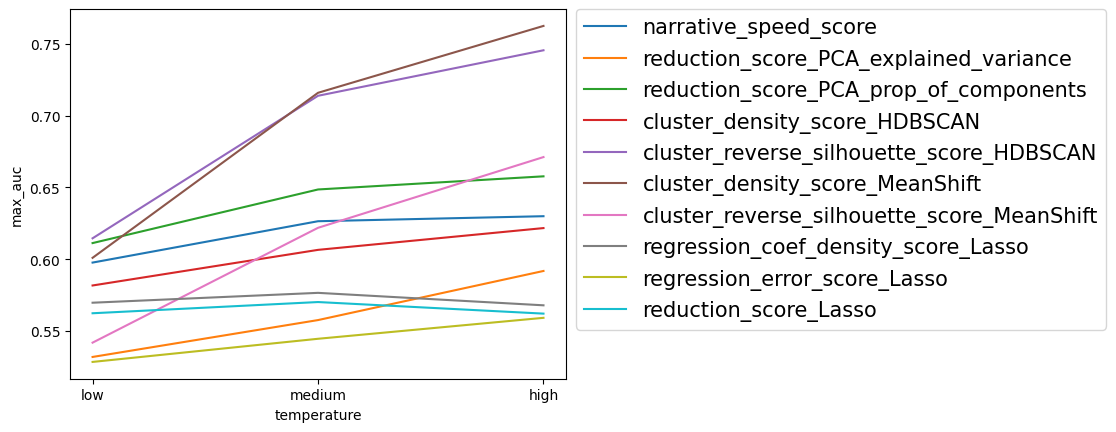

In [81]:
sns.lineplot(data = df_results_1[df_results_1.feature_name.isin(scores)], hue = "feature_name", y = "max_auc" ,x= "temperature")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize = 15)

In [77]:
df_results_1

n_features                                           features  \
0            1                            [narrative_speed_score]   
1            1           [reduction_score_PCA_explained_variance]   
2            1           [reduction_score_PCA_prop_of_components]   
3            1                    [cluster_density_score_HDBSCAN]   
4            1         [cluster_reverse_silhouette_score_HDBSCAN]   
..         ...                                                ...   
121          1  [sentence_sim_all_cosine_sentences_similarity_...   
122          1  [lemma_consecutive_jaccard_sentences_similarit...   
123          1  [lemma_consecutive_jaccard_sentences_similarit...   
124          1      [lemma_all_jaccard_sentences_similarity_mean]   
125          1       [lemma_all_jaccard_sentences_similarity_std]   

                                          feature_name    auc_lr    auc_rf  \
0                                narrative_speed_score  0.597622  0.525678   
1               reduction_score_PCA_explained_variance   0.53182  0.494818   
2               reduction_score_PCA_prop_of_components   0.61122  0.601396   
3                        cluster_density_score_HDBSCAN  0.558027  0.581067   
4             cluster_reverse_silhouette_score_HDBSCAN  0.406173  0.550823   
..                                                 ...       ...       ...   
121   sentence_sim_all_cosine_sentences_similarity_std  0.777688  0.677707   
122  lemma_consecutive_jaccard_sentences_similarity...  0.595372  0.530738   
123  lemma_consecutive_jaccard_sentences_similarity...  0.628462  0.584879   
124        lemma_all_jaccard_sentences_similarity_mean  0.640037  0.555483   
125         lemma_all_jaccard_sentences_similarity_std  0.850061   0.77166   

      auc_xgb temperature   max_auc  
0    0.573904         low  0.597622  
1    0.516555         low   0.53182  
2     0.60202         low   0.61122  
3    0.581657         low  0.581657  
4    0.614556         low  0.614556  
..        ...         ...       ...  
121   0.75905        high  0.777688  
122  0.570277        high  0.595372  
123  0.627808        high  0.628462  
124  0.592369        high  0.640037  
125  0.834352        high  0.850061  

[126 rows x 8 columns]

In [75]:
df_results_1[df_results_1.temperature == temp].sort_values('max_auc', ascending = False)[:15]

n_features                                           features  \
125          1       [lemma_all_jaccard_sentences_similarity_std]   
107          1       [fast_text_all_wmd_sentences_similarity_std]   
99           1             [w2v_all_wmd_sentences_similarity_std]   
121          1  [sentence_sim_all_cosine_sentences_similarity_...   
115          1           [glove_all_wmd_sentences_similarity_std]   
89           1                  [cluster_density_score_MeanShift]   
88           1         [cluster_reverse_silhouette_score_HDBSCAN]   
90           1       [cluster_reverse_silhouette_score_MeanShift]   
86           1           [reduction_score_PCA_prop_of_components]   
124          1      [lemma_all_jaccard_sentences_similarity_mean]   
119          1  [sentence_sim_consecutive_cosine_sentences_sim...   
84           1                            [narrative_speed_score]   
123          1  [lemma_consecutive_jaccard_sentences_similarit...   
109          1  [fast_text_consecutive_wmd_sentences_similarit...   
117          1   [glove_consecutive_wmd_sentences_similarity_std]   

                                          feature_name    auc_lr    auc_rf  \
125         lemma_all_jaccard_sentences_similarity_std  0.850061   0.77166   
107         fast_text_all_wmd_sentences_similarity_std   0.81978  0.729579   
99                w2v_all_wmd_sentences_similarity_std  0.811887  0.728678   
121   sentence_sim_all_cosine_sentences_similarity_std  0.777688  0.677707   
115             glove_all_wmd_sentences_similarity_std  0.767966  0.676843   
89                     cluster_density_score_MeanShift  0.669379  0.762645   
88            cluster_reverse_silhouette_score_HDBSCAN  0.430297  0.668679   
90          cluster_reverse_silhouette_score_MeanShift   0.41041  0.608813   
86              reduction_score_PCA_prop_of_components  0.657765  0.655367   
124        lemma_all_jaccard_sentences_similarity_mean  0.640037  0.555483   
119  sentence_sim_consecutive_cosine_sentences_simi...  0.638907  0.556645   
84                               narrative_speed_score  0.629961  0.540528   
123  lemma_consecutive_jaccard_sentences_similarity...  0.628462  0.584879   
109  fast_text_consecutive_wmd_sentences_similarity...  0.626875  0.577965   
117     glove_consecutive_wmd_sentences_similarity_std  0.624256  0.551379   

      auc_xgb temperature   max_auc  
125  0.834352        high  0.850061  
107   0.80258        high   0.81978  
99   0.796873        high  0.811887  
121   0.75905        high  0.777688  
115  0.745218        high  0.767966  
89   0.762641        high  0.762645  
88   0.745659        high  0.745659  
90   0.671191        high  0.671191  
86   0.655334        high  0.657765  
124  0.592369        high  0.640037  
119  0.614039        high  0.638907  
84   0.587647        high  0.629961  
123  0.627808        high  0.628462  
109  0.610986        high  0.626875  
117  0.603502        high  0.624256

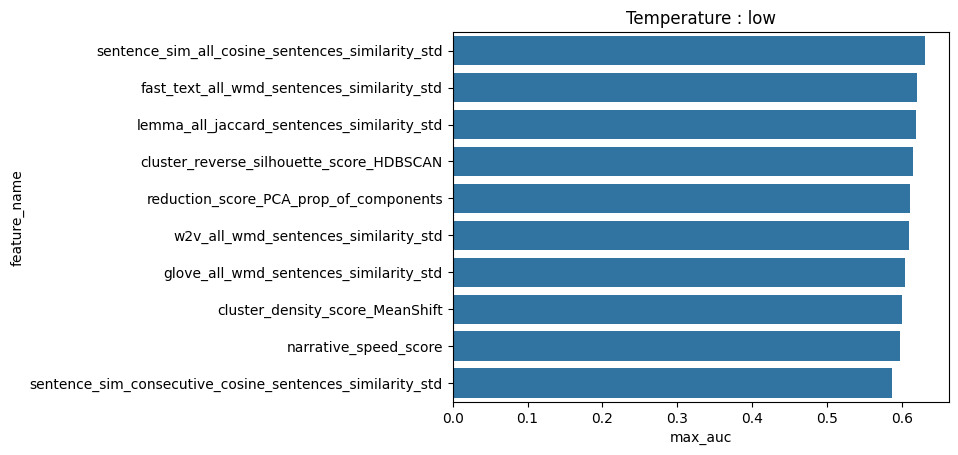

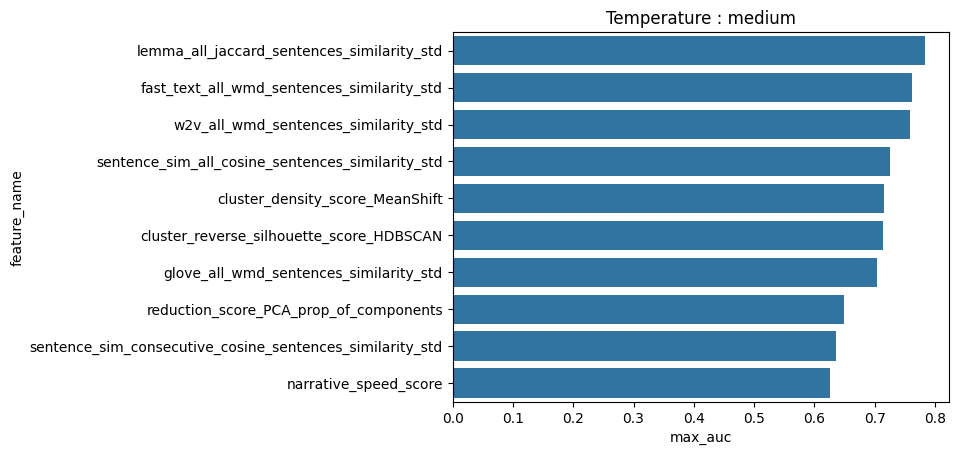

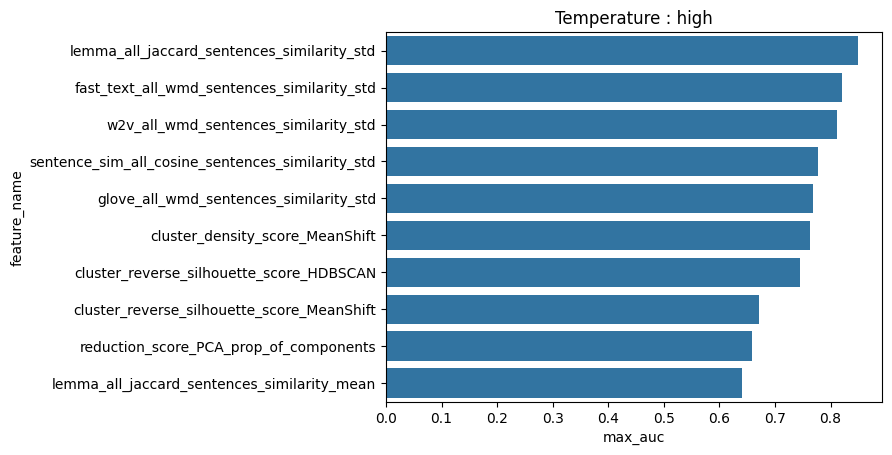

In [73]:
df_results_1['max_auc'] = df_results_1[['auc_lr', 'auc_rf',"auc_xgb"]].max(axis=1)
for temp in ['low', 'medium', 'high']:
    test = df_results_1[df_results_1.temperature == temp].sort_values('max_auc', ascending = False)[:10]
    sns.barplot(data = test, y = 'feature_name', x = 'max_auc',)
    plt.title(f"Temperature : {temp}")
    plt.show()

In [62]:
df_results_2.to_csv('features_type_auc_results.csv', index=False)

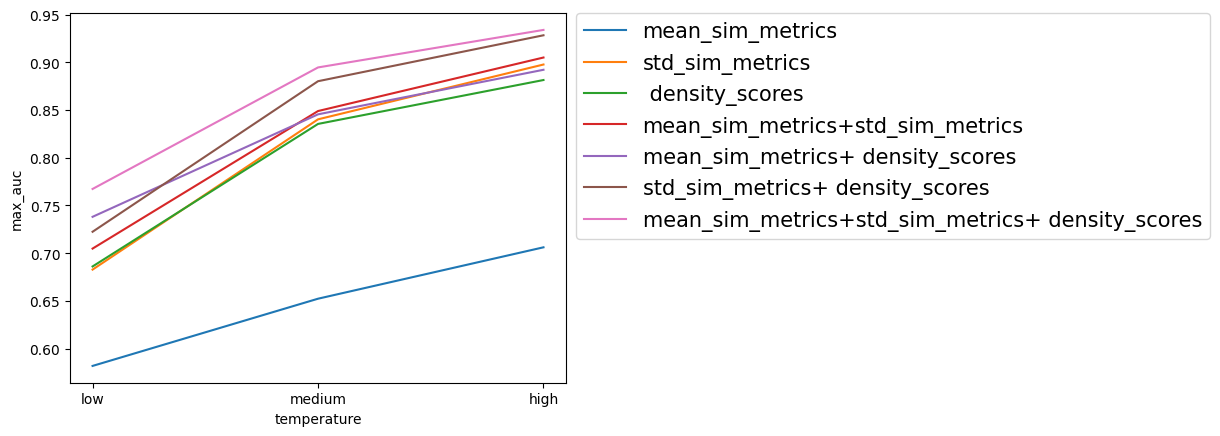

In [53]:
   
df_results_2['max_auc'] = df_results_2[['auc_lr', 'auc_rf',"auc_xgb"]].max(axis=1)
df_results_2['feature_name_new'] = df_results_2['feature_name'].apply(lambda x : x.replace("scores", " density_scores"))
sns.lineplot(data = df_results_2, hue = "feature_name_new", y = "max_auc" ,x= "temperature")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize = 15)

In [28]:
from sklearn.feature_selection import RFE



def cross_validation_performance(X, y, estimator, n_features_to_select, cv=5, scoring='roc_auc'):
    scores = []
    for n_features in n_features_to_select:
        rfe = RFE(estimator, n_features_to_select=n_features)
        X_selected = rfe.fit_transform(X, y)
        score = cross_val_score(estimator, X_selected, y, cv=cv, scoring=scoring)

        scores.append(score.mean())
    return np.array(scores)


# estimator = LogisticRegression(penalty='l1', solver='liblinear')
estimator = RandomForestClassifier()
n_features_to_select = [1,2,3,4,5,10,15,20,25,30,35,40]

X = semantic_repetition_data[all_features]
y = semantic_repetition_data['has_paraphrase']
cv_scores = cross_validation_performance(X, y, estimator, n_features_to_select)
best_n_features = n_features_to_select[np.argmax(cv_scores)]

In [18]:
def encode_temperature(temperature):
    if temperature <2 :
        return "low"
    elif temperature <4 :
        return "medium"
    else : 
        return "high"

data['temperature_enc'] = data['temperature'].apply(encode_temperature)
data['temperature_enc'].value_counts()

temperature_enc
medium    6673
low       6543
high      5632
Name: count, dtype: int64

In [80]:
low_temp_para = data[(data.temperature_enc=="low") & (data.has_paraphrase==0) ]
high_temp_no_para = data[(data.temperature_enc=="high") & (data.has_paraphrase==0)]

study4 = pd.concat([low_temp_para, high_temp_no_para]).reset_index()
dataset = data
print(len(study4))
target  = 'temperature_enc'
results = compare_models(models, dataset[all_features], dataset[target], dataset['prompt_cat'], extract_shap_val=False)

6543
AUC scores: [nan nan nan nan nan]
Mean AUC: nan


#############
Temperature: low
AUC scores: [0.72851277 0.72475769 0.72071923 0.6954479  0.69161633]
Mean AUC: 0.7122107814112424
Model type not yet supported by TreeExplainer: <class 'sklearn.linear_model._logistic.LogisticRegression'>
AUC scores: [0.80222839 0.74978554 0.75180922 0.7068409  0.70728198]
Mean AUC: 0.7435892059521748


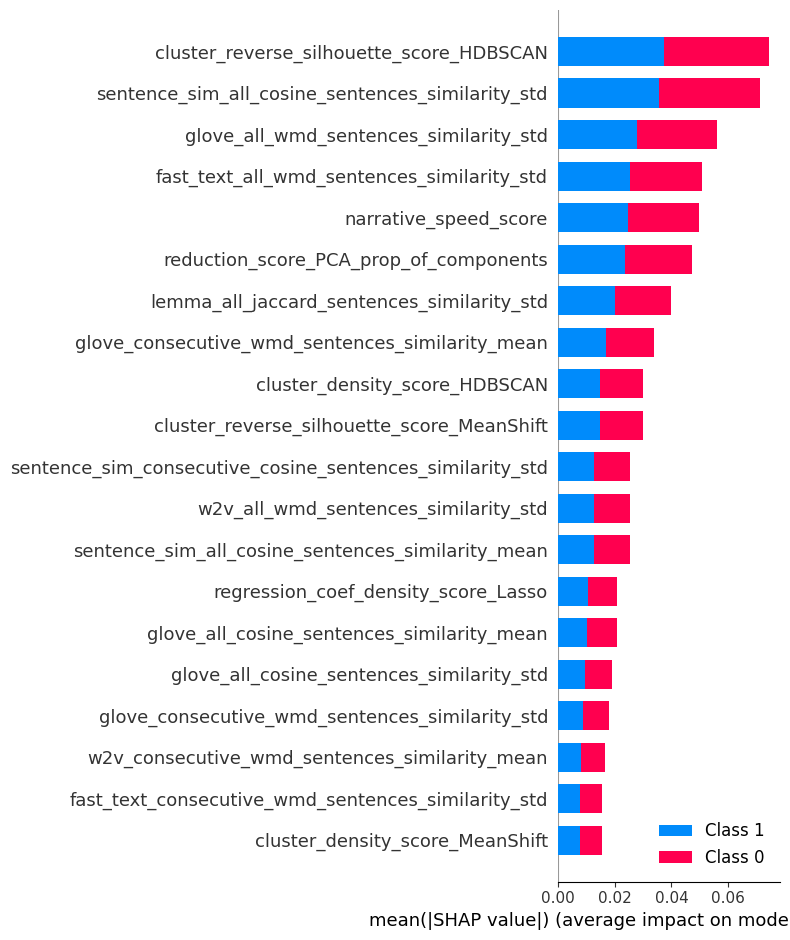

#############
Temperature: medium
AUC scores: [0.85268007 0.83228135 0.84726301 0.82956181 0.82532097]
Mean AUC: 0.8374214417250039
Model type not yet supported by TreeExplainer: <class 'sklearn.linear_model._logistic.LogisticRegression'>
AUC scores: [0.88309315 0.85959074 0.91426476 0.8748117  0.86993132]
Mean AUC: 0.8803383343387606


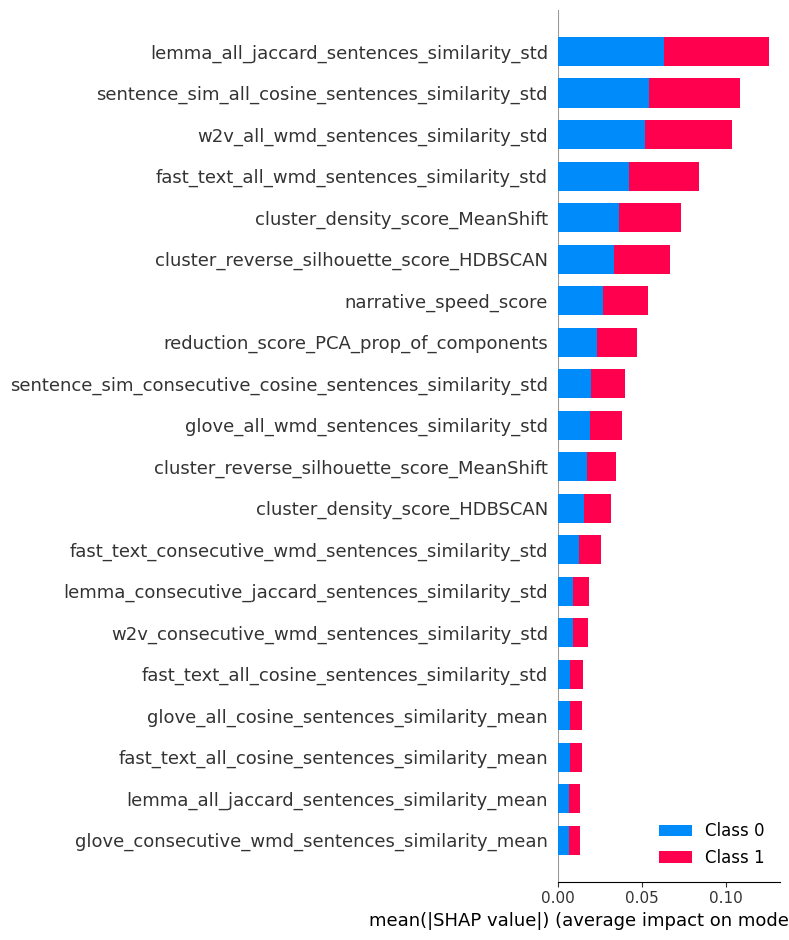

#############
Temperature: high
AUC scores: [0.8928924  0.88422509 0.86278035 0.91242671 0.87287762]
Mean AUC: 0.8850404342894439
Model type not yet supported by TreeExplainer: <class 'sklearn.linear_model._logistic.LogisticRegression'>
AUC scores: [0.92339426 0.92485432 0.90989573 0.95310668 0.91365256]
Mean AUC: 0.9249807081071199


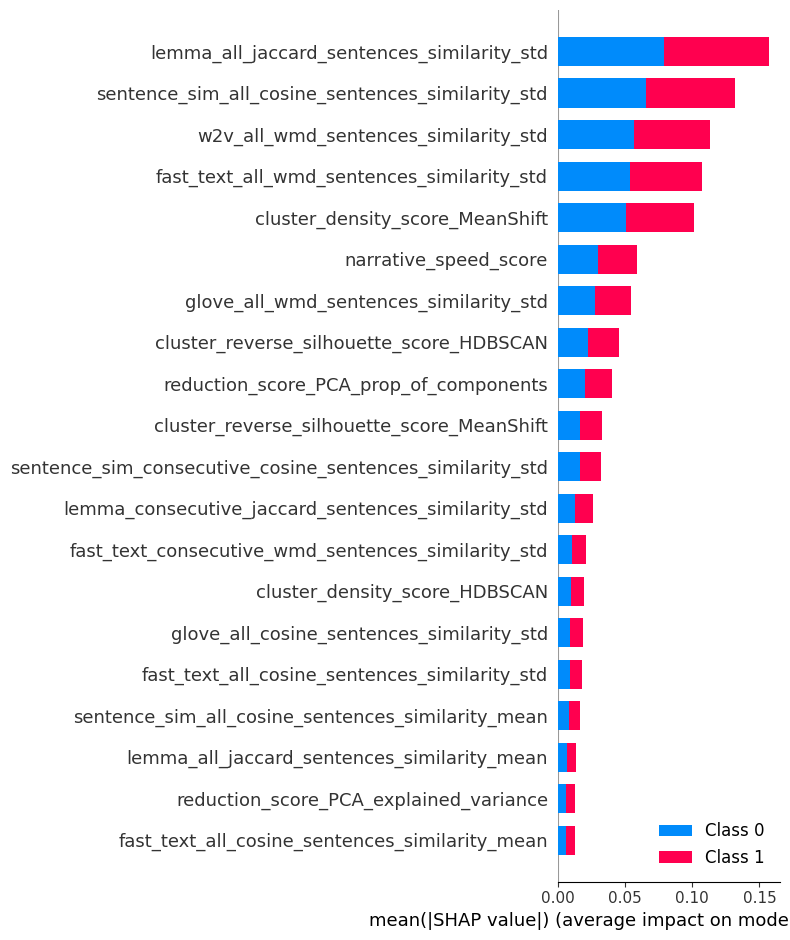

In [32]:

for temp in ['low', 'medium', 'high']:
    print("#############")
    print(f"Temperature: {temp}")
    dataset = data[data['temperature_enc'] == temp]
    results = compare_models(models, dataset[all_features], dataset[target], dataset['prompt_cat'], extract_shap_val=True)


AUC scores: [0.79557698 0.74977161 0.75775693 0.71379205 0.70636457]
Mean AUC: 0.7446524278204464


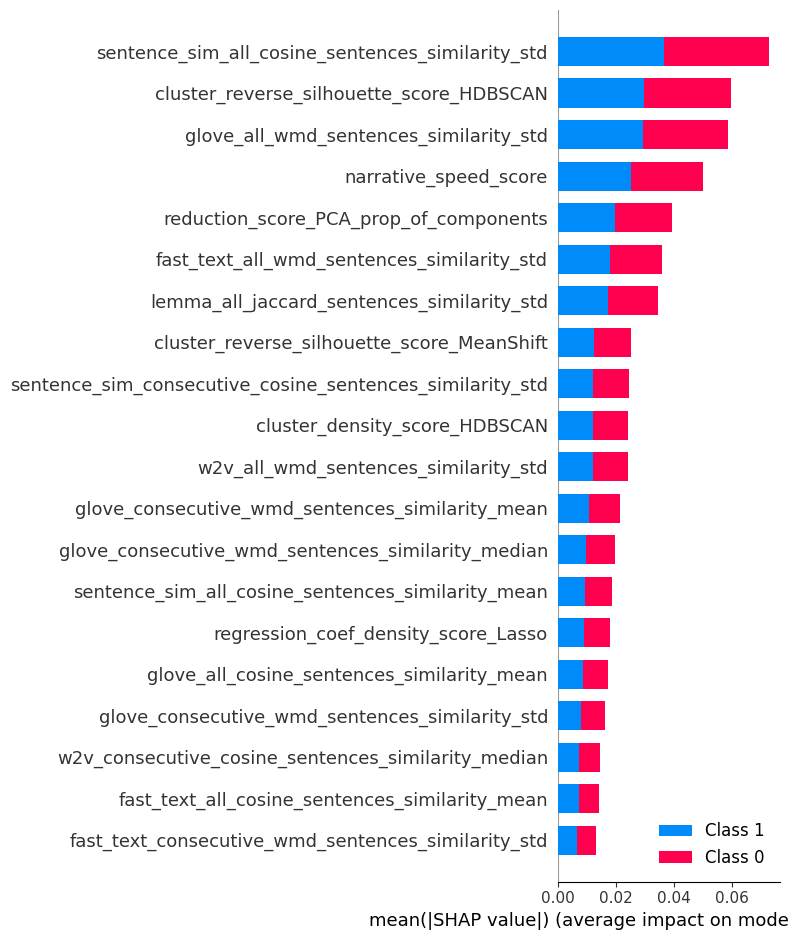

AUC scores: [0.878675   0.86073544 0.91104206 0.87119709 0.86743078]
Mean AUC: 0.8778160738271283


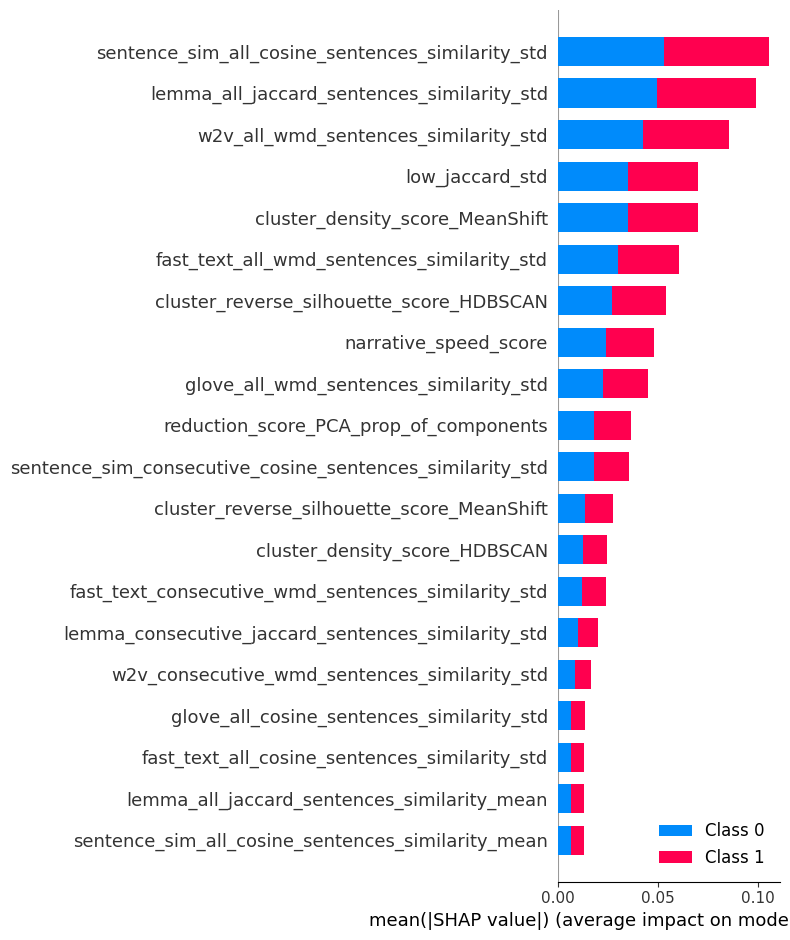

AUC scores: [0.92097932 0.92227534 0.9094039  0.95528158 0.91458854]
Mean AUC: 0.9245057350439918


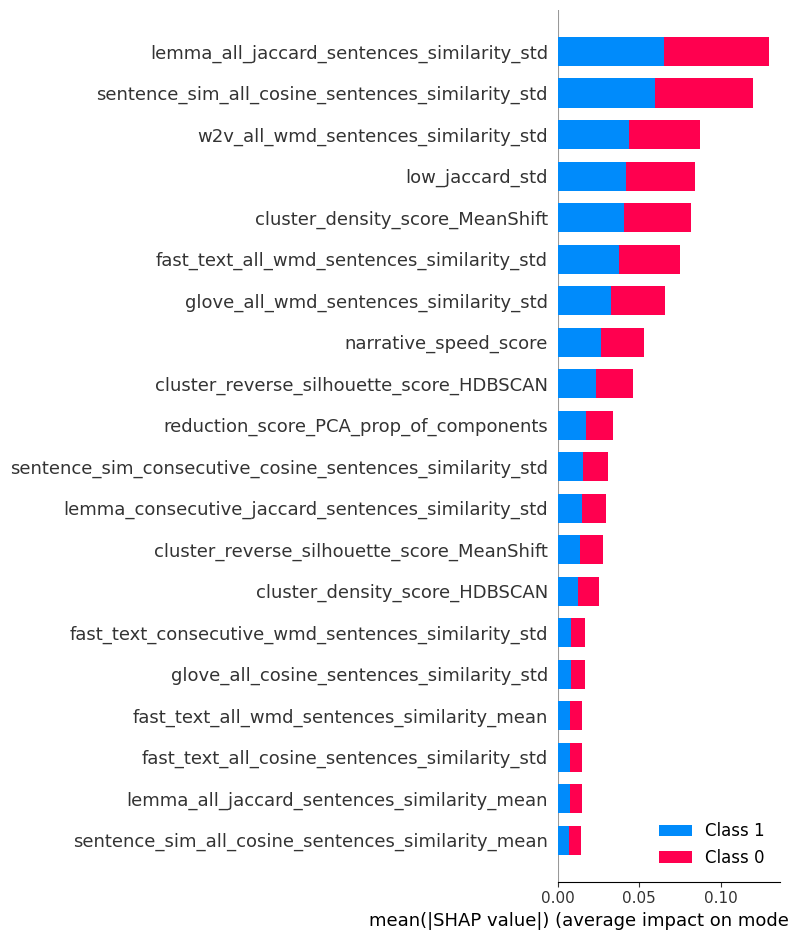

In [19]:
models = {
    #"Logistic Regression": "LR",
    "Random Forest": "random_forest",
    #"XGBoost": "xgb",
    #"SVM": "svm",
    #"Kernel SVM": "kernel_svm"
}

target  = 'has_paraphrase'
dataset = data[data['had_paraphrase']==0]
for temp in ['low',"medium","high"]:
    dataset = data[data.temperature_enc==temp]
    results = compare_models(models, dataset[all_features], dataset[target], dataset['prompt_cat'], extract_shap_val=True)
    #clf, perf, shap_values = pipeline(not_roc_data[all_features], not_roc_data[target])
    results

In [20]:
len(data)

18848

In [26]:
jaccard_median = data[data.lemma_para_vs_others_jaccard_sentences_similarity>-1].lemma_para_vs_others_jaccard_sentences_similarity.median()
data['has_only_semantic_repetition'] = data['lemma_para_vs_others_jaccard_sentences_similarity'].apply(lambda x: 1 if  -1<x< jaccard_median else  0)


In [4]:
jaccard_std_median = data.lemma_all_jaccard_sentences_similarity_std.median()
data['low_jaccard_std'] = data['lemma_all_jaccard_sentences_similarity_std'].apply(lambda x: 1 if x< jaccard_std_median else  0)

In [37]:
data[data['low_jaccard_std']==1].has_paraphrase.value_counts()

has_paraphrase
0    6688
1    2736
Name: count, dtype: int64

AUC scores: [0.75760349 0.64577452 0.67861231 0.73529775 0.73963585]
Mean AUC: 0.7113847855886927


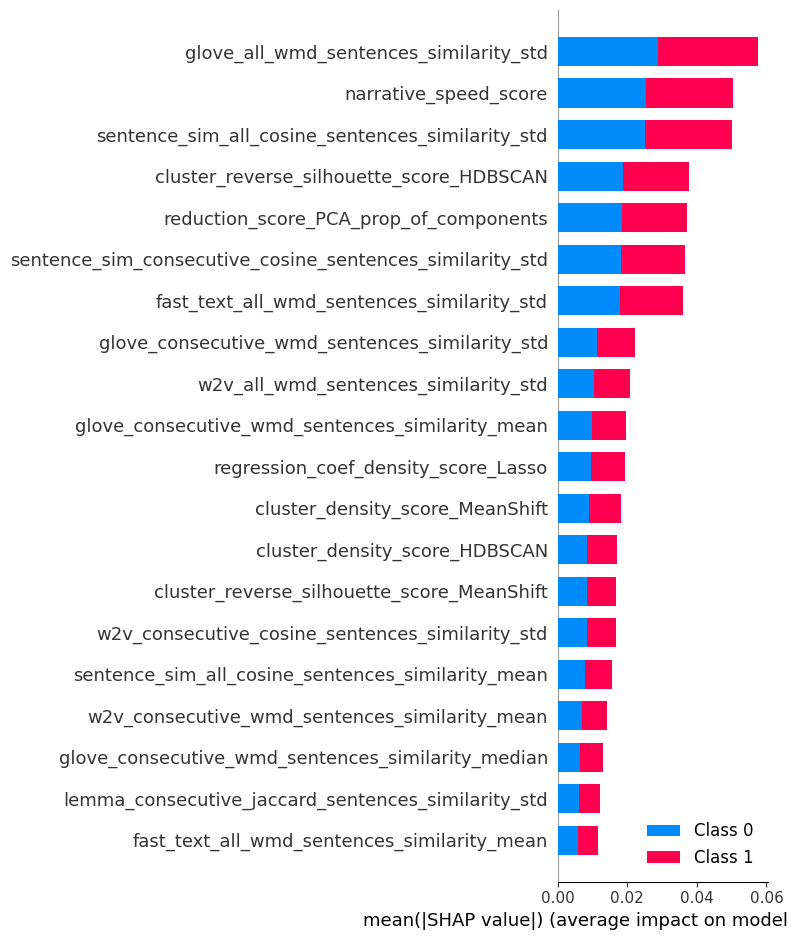

AUC scores: [0.79573186 0.84074318 0.83759694 0.81083038 0.82556138]
Mean AUC: 0.8220927481377901


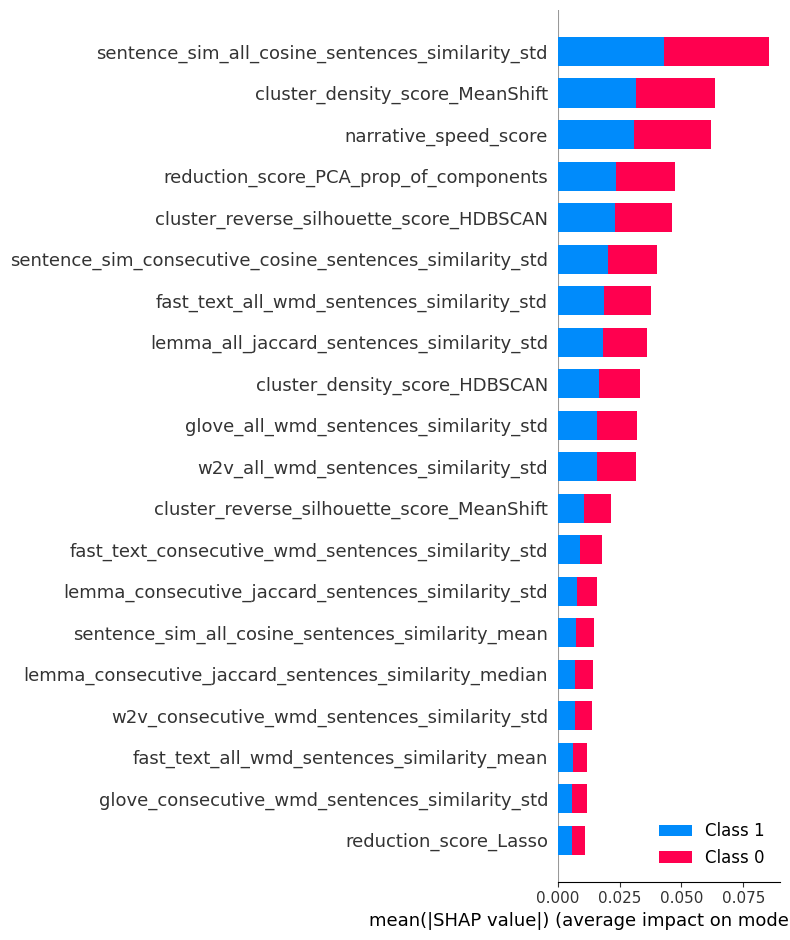

AUC scores: [0.88864997 0.87629539 0.88845558 0.87302975 0.8639433 ]
Mean AUC: 0.8780747965897703


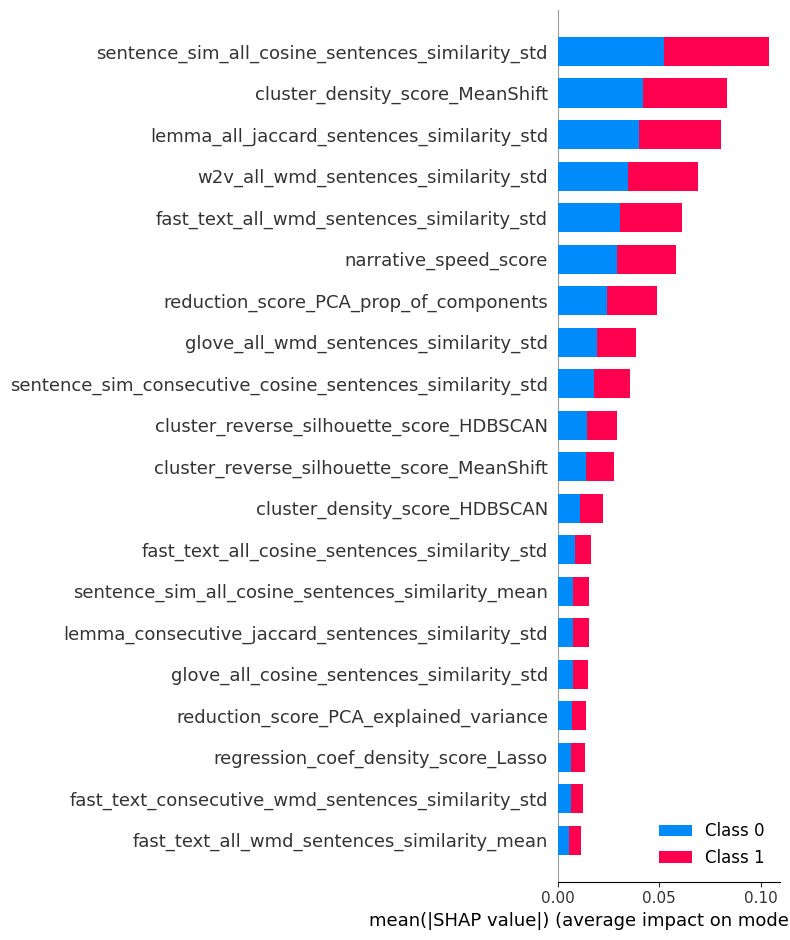

In [22]:
models = {
    #"Logistic Regression": "LR",
    "Random Forest": "random_forest",
    #"XGBoost": "xgb",
}

target  = 'has_paraphrase'
semantic_repetition_data = data[data.low_jaccard_std==1]
for temp in ['low', "medium","high"]:
    dataset = semantic_repetition_data[semantic_repetition_data.temperature_enc==temp]
    results = compare_models(models, dataset[all_features], dataset[target],dataset["prompt_cat"],extract_shap_val=True)
    #clf, perf, shap_values = pipeline(not_roc_data[all_features], not_roc_data[target])
    results

AUC scores: [0.79657525 0.77616565 0.81153395 0.80118299 0.76787274]
Mean AUC: 0.7906661153212658
The passed model is not callable and cannot be analyzed directly with the given masker! Model: LogisticRegression()
AUC scores: [0.8495662  0.79939131 0.84996077 0.82778087 0.78715724]
Mean AUC: 0.8227712769485805


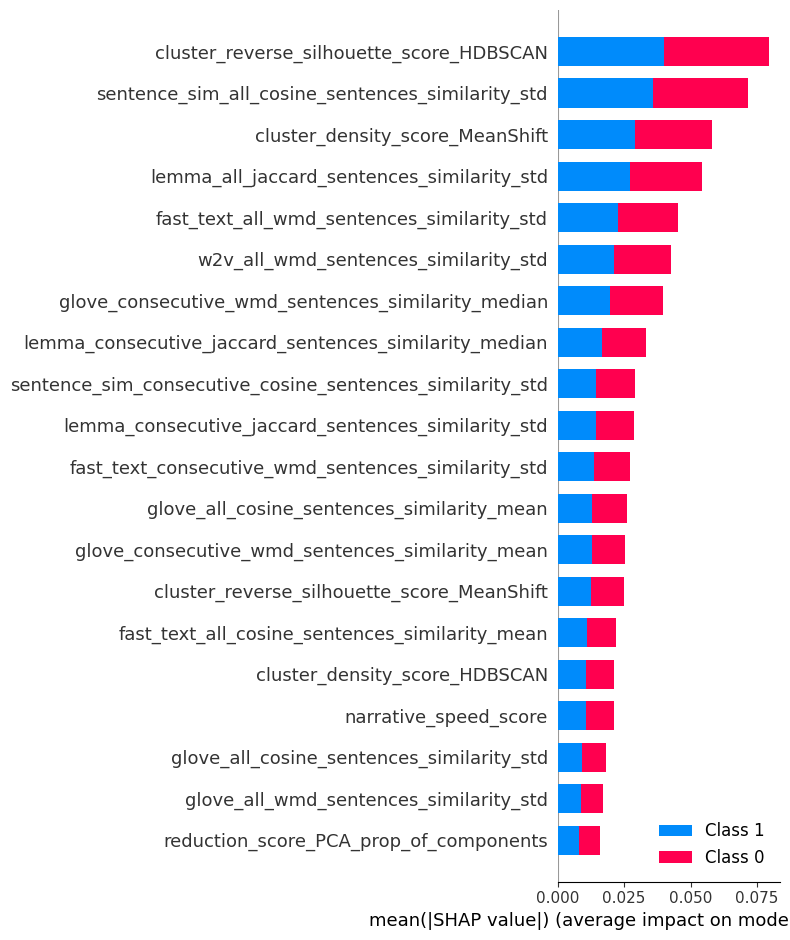

Logistic Regression  Random Forest
Mean AUC             0.790666       0.822771

In [7]:
models = {
    "Logistic Regression": "LR",
    "Random Forest": "random_forest",
    #"XGBoost": "xgb",
}

target  = 'has_paraphrase'
semantic_repetition_data = data[data.low_jaccard_std==0]

results = compare_models(models, semantic_repetition_data[all_features], semantic_repetition_data[target],semantic_repetition_data["prompt_cat"],extract_shap_val=True)
#clf, perf, shap_values = pipeline(not_roc_data[all_features], not_roc_data[target])
results

In [11]:
# question: Does the paraphrase process have an impact the generated text, even when removed from the final output?

no_para_data = data[data['has_paraphrase'] == 0]
print(len( no_para_data))

no_para_data['had_paraphrase'].value_counts()

4195


had_paraphrase
True     3494
False     701
Name: count, dtype: int64

AUC scores: [0.58803922 0.62899859 0.62534995 0.60465116 0.52371192]
Mean AUC: 0.5941501699086821
The passed model is not callable and cannot be analyzed directly with the given masker! Model: LogisticRegression()
AUC scores: [0.55794966 0.5664362  0.59622793 0.57186849 0.52653676]
Mean AUC: 0.5638038085596015


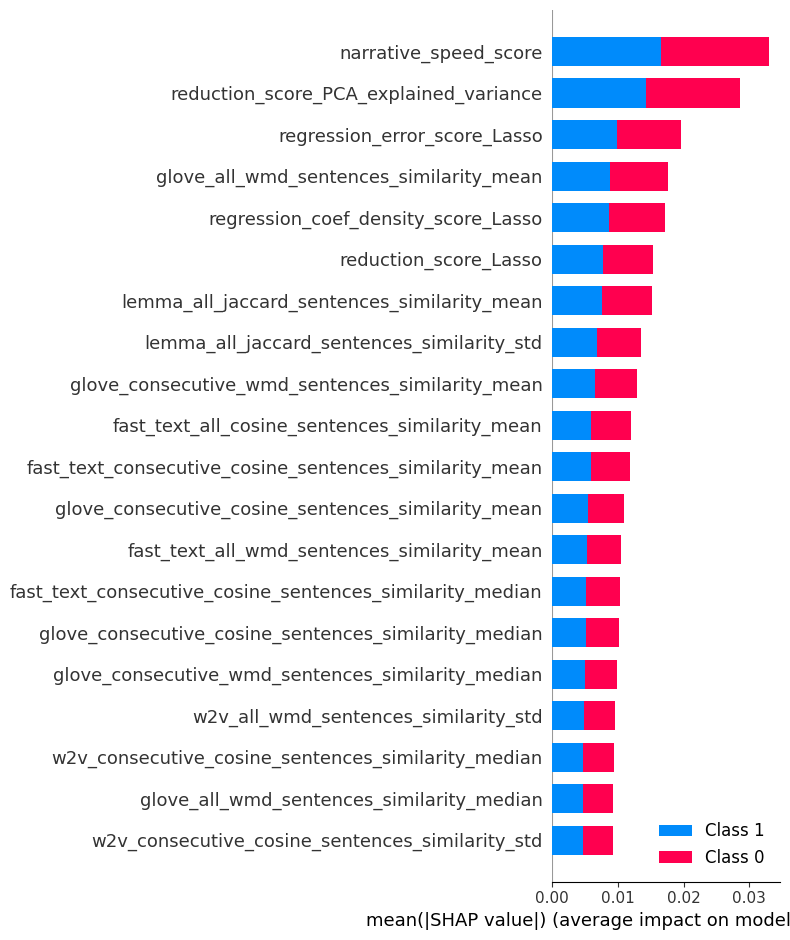

Logistic Regression  Random Forest
Mean AUC              0.59415       0.563804

In [9]:
models = {
    "Logistic Regression": "LR",
    "Random Forest": "random_forest",
    #"XGBoost": "xgb",
}

target  = 'had_paraphrase'
no_para_data = data[data['has_paraphrase'] == 0]

results = compare_models(models, no_para_data[all_features], no_para_data[target],no_para_data["prompt_cat"],extract_shap_val=True)
#clf, perf, shap_values = pipeline(not_roc_data[all_features], not_roc_data[target])
results

In [10]:
def define_distant(index, num_sentences):
    if index== None :
        return 0
    if len(index) == 0:
        return 0
    if (index[1]-index[0])/num_sentences>0.25:
        return 1
    else:
        return 0 

no_para_data['had_distant_paraphrase'] = no_para_data.apply(lambda x: define_distant(x.clean_paraphrase_index, x.num_sentences), axis=1)

In [11]:
no_para_data['had_distant_paraphrase'].value_counts()

had_distant_paraphrase
0    6885
1    3299
Name: count, dtype: int64

In [15]:
study_2 = no_para_data[(no_para_data.had_paraphrase == 0) | (no_para_data.had_distant_paraphrase == 1)]
study_2.had_paraphrase.value_counts()

had_paraphrase
True     1173
False     701
Name: count, dtype: int64

In [12]:
models = {
    "Logistic Regression": "LR",
    "Random Forest": "random_forest",
    "XGBoost": "xgb",
}

target  = 'had_paraphrase'


results = compare_models(models, study_2[all_features], study_2[target],study_2["group"],extract_shap_val=True)
#clf, perf, shap_values = pipeline(not_roc_data[all_features], not_roc_data[target])
results
# need to check where the paraphrasing is happening in the text

NameError: name 'study_2' is not defined

In [ ]:
import itertools

list(itertools.combinations(all_features, k))

In [15]:
## Features selection
import itertools
target = "has_paraphrase"
models = {
    "Logistic Regression": "LR",
    "Random Forest": "random_forest",
    "XGBoost": "xgb",
}

df_results_2 = pd.DataFrame(columns=["features", "auc_lr", "auc_rf", "auc_xgb"])
i = 0

for k in range(1, 2):
    feature_combinations = list(itertools.combinations(all_features, k))
    for feature_combination in feature_combinations:
        print("#######")
        print(f"n = {i}")
        print(feature_combination)
        results = compare_models(models, data[list(feature_combination)], data[target], data['prompt_cat'], extract_shap_val=False)
        r = {}
        r['n_features'] = len(feature_combination)
        r["features"] = feature_combination
        r['auc_lr'] = results["Logistic Regression"].values[0]
        r['auc_rf'] = results["Random Forest"].values[0]
        r['auc_xgb'] = results["XGBoost"].values[0]
        df_results_2.loc[i] = pd.Series(r)
        
        print(r)
        i+=1

#######
n = 0
('narrative_speed_score',)
AUC scores: [0.59031209 0.59105569 0.59680444 0.59064396 0.58762596]
Mean AUC: 0.5912884284527424
AUC scores: [0.5398331  0.52984215 0.52762171 0.52079905 0.52342536]
Mean AUC: 0.5283042756535196
AUC scores: [0.57216431 0.56959898 0.58091169 0.56787241 0.57874381]
Mean AUC: 0.5738582401841731
{'n_features': 1, 'features': ('narrative_speed_score',), 'auc_lr': 0.5912884284527424, 'auc_rf': 0.5283042756535196, 'auc_xgb': 0.5738582401841731}
#######
n = 1
('reduction_score_PCA_explained_variance',)
AUC scores: [0.56348785 0.57623794 0.55768252 0.54925079 0.54851737]
Mean AUC: 0.5590352965225092
AUC scores: [0.50808132 0.50873164 0.54841591 0.50999918 0.50353148]
Mean AUC: 0.5157519069566303
AUC scores: [0.54200356 0.54000319 0.55056396 0.52527918 0.52785225]
Mean AUC: 0.5371404264587218
{'n_features': 1, 'features': ('reduction_score_PCA_explained_variance',), 'auc_lr': 0.5590352965225092, 'auc_rf': 0.5157519069566303, 'auc_xgb': 0.5371404264587218

KeyboardInterrupt: 

In [ ]:
df_results_2.sort_values(by="auc_lr", ascending=False).iloc[0][['features',"auc_lr"]]

features    (reduction_score_PCA_prop_of_components, clust...
auc_lr                                               0.686392
Name: 110, dtype: object

In [32]:
df_results.sort_values(by="auc_lr", ascending=False).iloc[0][['features',"auc_lr"]]

features    (cluster_silhouette_score_HDBSCAN,)
auc_lr                                 0.674585
Name: 4, dtype: object